# Collaboration and Competition

---


### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import time
from agent.agent import MADDPG
import torch

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


When finished, you can close the environment.

# MADDPG

* for episode = 1 to M do:
    * init random process N for action exploration
    * recieve initial state x
    * for t=1 to max-episode-length do:
        * for each agent i, select action with the current agent policy + noise
        * execute actions and observe reward r and new state
        * store (x, a,r, x') in replay buffer
        * x<-x'
        * for agent i=1 to N do:
            * sample a random minibatch of S samples $(x^j, a^j, r^j, x'^j)$ from $D$
            * run gradient descent on sampled policy gradient and update actor-critic

## hyper-parameters
* learning rate: 0.01
* $\tau = 0.01$ for soft-updates
* $\gamma = 0.95 $
* replay buffer size: $10^6$
* update frequency: 100 samples added to replay buffer
* batch-size: 1024   

In [5]:
agent = MADDPG(state_size, action_size)

agent using cuda:0 device
agent using cuda:0 device


In [6]:
def train(n_episodes=3000):
    scores = []
    scores_deque = deque(maxlen=100)
    scores_avg = []
    max_score = 0
    
    for i_episode in range(1,n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        # get initial state
        states = env_info.vector_observations
        agent.reset()
        
        #loop over episodes
        agent_scores = np.zeros(2)
        start_time = time.time()
        while True:
            # select actions for all agents
            actions = agent.act(states)
                       
            # send action to env
            env_info = env.step(actions)[brain_name]
            
            #observe new state, reward
            next_states = env_info.vector_observations
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                       # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)
            
            #update state
            states = next_states
            
            #add agent scores individually
            agent_scores += np.array(rewards)
            
            if any(dones):
                break
        #get max score
        score = agent_scores.max()
        scores.append(score)
        scores_deque.append(score)        
        scores_avg.append(np.mean(scores_deque))
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f} \tTime: {:.2f}'.format(i_episode, 
                                                                                         np.mean(scores_deque), 
                                                                                         np.mean(scores), 
                                                                                         time.time()-start_time), end="")
        if np.mean(scores_deque)>max_score:
            max_score = np.mean(scores_deque)
#             for i, a in enumerate(agent.ddpg_agents):
#                 try:
# #                     torch.save(a.actor_local.state_dict(), 'checkpoint_actor_{}.pth'.format(i))
# #                     torch.save(a.critic_local.state_dict(), 'checkpoint_critic_{}.pth'.format(i))
#                 except:
#                     print("error saving model")
        if np.mean(scores_deque)>0.5 and np.mean(scores_deque)<max_score:
            print("solved in {} episodes".format(i_episode))
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} \tMax score: {:.2f} \tEpsilon: {:.2f} \tTime: {:.2f}/per episode'.format(i_episode, 
                                                                                                                                np.mean(scores_deque),
                                                                                                                                np.max(scores_deque),
                                                                                                                                agent.ddpg_agents[0].epsilon,
                                                                                                                                time.time()-start_time))
    return scores, scores_avg

In [7]:
scores, moving_averages = train()

Episode 100	Average Score: 0.01 	Max score: 0.10 	Epsilon: 1.00 	Time: 0.05/per episode
Episode 200	Average Score: 0.01 	Max score: 0.10 	Epsilon: 1.00 	Time: 0.47/per episode
Episode 300	Average Score: 0.00 	Max score: 0.00 	Epsilon: 0.99 	Time: 0.04/per episode
Episode 400	Average Score: 0.01 	Max score: 0.10 	Epsilon: 0.99 	Time: 0.45/per episode
Episode 500	Average Score: 0.01 	Max score: 0.10 	Epsilon: 0.99 	Time: 0.05/per episode
Episode 600	Average Score: 0.05 	Max score: 0.10 	Epsilon: 0.98 	Time: 0.52/per episode
Episode 700	Average Score: 0.08 	Max score: 0.20 	Epsilon: 0.97 	Time: 0.49/per episode
Episode 800	Average Score: 0.08 	Max score: 0.20 	Epsilon: 0.97 	Time: 0.53/per episode
Episode 900	Average Score: 0.12 	Max score: 0.40 	Epsilon: 0.96 	Time: 0.09/per episode
Episode 1000	Average Score: 0.13 	Max score: 0.40 	Epsilon: 0.95 	Time: 0.47/per episode
Episode 1100	Average Score: 0.13 	Max score: 0.40 	Epsilon: 0.94 	Time: 1.02/per episode
Episode 1200	Average Score: 0.

Episode 1596	Average Score: 0.78	Score: 0.16 	Time: 6.98solved in 1596 episodes
Episode 1597	Average Score: 0.78	Score: 0.16 	Time: 1.06solved in 1597 episodes
Episode 1598	Average Score: 0.78	Score: 0.16 	Time: 0.72solved in 1598 episodes
Episode 1599	Average Score: 0.79	Score: 0.16 	Time: 4.40solved in 1599 episodes
Episode 1600	Average Score: 0.81 	Max score: 2.70 	Epsilon: 0.78 	Time: 11.46/per episode
Episode 1604	Average Score: 0.83	Score: 0.17 	Time: 0.03solved in 1604 episodes
Episode 1605	Average Score: 0.81	Score: 0.17 	Time: 1.04solved in 1605 episodes
Episode 1606	Average Score: 0.82	Score: 0.17 	Time: 6.92solved in 1606 episodes
Episode 1607	Average Score: 0.81	Score: 0.17 	Time: 1.87solved in 1607 episodes
Episode 1608	Average Score: 0.83	Score: 0.17 	Time: 5.60solved in 1608 episodes
Episode 1611	Average Score: 0.85	Score: 0.17 	Time: 2.83solved in 1611 episodes
Episode 1612	Average Score: 0.84	Score: 0.17 	Time: 1.13solved in 1612 episodes
Episode 1613	Average Score: 0.

Episode 1751	Average Score: 1.33	Score: 0.26 	Time: 1.70solved in 1751 episodes
Episode 1752	Average Score: 1.33	Score: 0.26 	Time: 11.15solved in 1752 episodes
Episode 1753	Average Score: 1.32	Score: 0.26 	Time: 0.52solved in 1753 episodes
Episode 1754	Average Score: 1.34	Score: 0.26 	Time: 10.43solved in 1754 episodes
Episode 1755	Average Score: 1.32	Score: 0.26 	Time: 3.58solved in 1755 episodes
Episode 1756	Average Score: 1.33	Score: 0.26 	Time: 1.81solved in 1756 episodes
Episode 1757	Average Score: 1.33	Score: 0.26 	Time: 1.29solved in 1757 episodes
Episode 1758	Average Score: 1.33	Score: 0.26 	Time: 12.18solved in 1758 episodes
Episode 1759	Average Score: 1.31	Score: 0.26 	Time: 0.64solved in 1759 episodes
Episode 1760	Average Score: 1.31	Score: 0.26 	Time: 12.31solved in 1760 episodes
Episode 1761	Average Score: 1.30	Score: 0.26 	Time: 0.56solved in 1761 episodes
Episode 1762	Average Score: 1.28	Score: 0.26 	Time: 0.65solved in 1762 episodes
Episode 1763	Average Score: 1.25	Sco

Episode 1853	Average Score: 0.92	Score: 0.30 	Time: 12.86solved in 1853 episodes
Episode 1854	Average Score: 0.90	Score: 0.30 	Time: 0.05solved in 1854 episodes
Episode 1855	Average Score: 0.91	Score: 0.30 	Time: 8.90solved in 1855 episodes
Episode 1856	Average Score: 0.93	Score: 0.30 	Time: 9.18solved in 1856 episodes
Episode 1857	Average Score: 0.93	Score: 0.30 	Time: 1.33solved in 1857 episodes
Episode 1858	Average Score: 0.90	Score: 0.30 	Time: 1.96solved in 1858 episodes
Episode 1859	Average Score: 0.91	Score: 0.30 	Time: 4.46solved in 1859 episodes
Episode 1860	Average Score: 0.89	Score: 0.30 	Time: 0.68solved in 1860 episodes
Episode 1861	Average Score: 0.89	Score: 0.30 	Time: 1.29solved in 1861 episodes
Episode 1862	Average Score: 0.89	Score: 0.30 	Time: 0.64solved in 1862 episodes
Episode 1863	Average Score: 0.89	Score: 0.30 	Time: 1.22solved in 1863 episodes
Episode 1864	Average Score: 0.89	Score: 0.30 	Time: 1.96solved in 1864 episodes
Episode 1865	Average Score: 0.88	Score:

Episode 1955	Average Score: 0.84	Score: 0.32 	Time: 12.61solved in 1955 episodes
Episode 1956	Average Score: 0.83	Score: 0.32 	Time: 4.73solved in 1956 episodes
Episode 1957	Average Score: 0.83	Score: 0.32 	Time: 1.34solved in 1957 episodes
Episode 1958	Average Score: 0.85	Score: 0.33 	Time: 13.49solved in 1958 episodes
Episode 1959	Average Score: 0.86	Score: 0.33 	Time: 7.42solved in 1959 episodes
Episode 1960	Average Score: 0.88	Score: 0.33 	Time: 13.61solved in 1960 episodes
Episode 1961	Average Score: 0.89	Score: 0.33 	Time: 4.77solved in 1961 episodes
Episode 1962	Average Score: 0.89	Score: 0.33 	Time: 0.61solved in 1962 episodes
Episode 1963	Average Score: 0.89	Score: 0.33 	Time: 0.68solved in 1963 episodes
Episode 1964	Average Score: 0.89	Score: 0.33 	Time: 1.47solved in 1964 episodes
Episode 1965	Average Score: 0.87	Score: 0.33 	Time: 0.65solved in 1965 episodes
Episode 1966	Average Score: 0.87	Score: 0.33 	Time: 0.63solved in 1966 episodes
Episode 1967	Average Score: 0.87	Scor

Episode 2057	Average Score: 0.85	Score: 0.35 	Time: 1.45solved in 2057 episodes
Episode 2058	Average Score: 0.83	Score: 0.35 	Time: 0.75solved in 2058 episodes
Episode 2059	Average Score: 0.83	Score: 0.35 	Time: 8.25solved in 2059 episodes
Episode 2060	Average Score: 0.80	Score: 0.35 	Time: 0.74solved in 2060 episodes
Episode 2061	Average Score: 0.82	Score: 0.35 	Time: 14.53solved in 2061 episodes
Episode 2062	Average Score: 0.82	Score: 0.35 	Time: 1.46solved in 2062 episodes
Episode 2063	Average Score: 0.84	Score: 0.35 	Time: 13.50solved in 2063 episodes
Episode 2064	Average Score: 0.87	Score: 0.35 	Time: 14.26solved in 2064 episodes
Episode 2065	Average Score: 0.89	Score: 0.35 	Time: 11.45solved in 2065 episodes
Episode 2066	Average Score: 0.91	Score: 0.36 	Time: 13.50solved in 2066 episodes
Episode 2067	Average Score: 0.91	Score: 0.36 	Time: 1.43solved in 2067 episodes
Episode 2068	Average Score: 0.90	Score: 0.36 	Time: 10.61solved in 2068 episodes
Episode 2069	Average Score: 0.91	S

Episode 2158	Average Score: 1.13	Score: 0.39 	Time: 9.31solved in 2158 episodes
Episode 2159	Average Score: 1.12	Score: 0.39 	Time: 0.86solved in 2159 episodes
Episode 2160	Average Score: 1.13	Score: 0.39 	Time: 4.41solved in 2160 episodes
Episode 2161	Average Score: 1.12	Score: 0.39 	Time: 11.75solved in 2161 episodes
Episode 2162	Average Score: 1.14	Score: 0.39 	Time: 15.35solved in 2162 episodes
Episode 2163	Average Score: 1.15	Score: 0.39 	Time: 15.42solved in 2163 episodes
Episode 2164	Average Score: 1.13	Score: 0.39 	Time: 3.00solved in 2164 episodes
Episode 2165	Average Score: 1.12	Score: 0.39 	Time: 6.13solved in 2165 episodes
Episode 2166	Average Score: 1.09	Score: 0.39 	Time: 1.53solved in 2166 episodes
Episode 2167	Average Score: 1.10	Score: 0.39 	Time: 4.52solved in 2167 episodes
Episode 2168	Average Score: 1.08	Score: 0.39 	Time: 1.60solved in 2168 episodes
Episode 2169	Average Score: 1.10	Score: 0.39 	Time: 9.87solved in 2169 episodes
Episode 2170	Average Score: 1.07	Scor

Episode 2259	Average Score: 1.05	Score: 0.42 	Time: 7.95solved in 2259 episodes
Episode 2260	Average Score: 1.05	Score: 0.42 	Time: 8.64solved in 2260 episodes
Episode 2261	Average Score: 1.04	Score: 0.42 	Time: 1.68solved in 2261 episodes
Episode 2262	Average Score: 1.01	Score: 0.42 	Time: 0.86solved in 2262 episodes
Episode 2263	Average Score: 0.99	Score: 0.42 	Time: 2.41solved in 2263 episodes
Episode 2264	Average Score: 1.01	Score: 0.42 	Time: 15.99solved in 2264 episodes
Episode 2265	Average Score: 1.02	Score: 0.42 	Time: 10.51solved in 2265 episodes
Episode 2266	Average Score: 1.02	Score: 0.42 	Time: 5.73solved in 2266 episodes
Episode 2267	Average Score: 1.02	Score: 0.42 	Time: 4.00solved in 2267 episodes
Episode 2268	Average Score: 1.04	Score: 0.42 	Time: 12.27solved in 2268 episodes
Episode 2269	Average Score: 1.02	Score: 0.42 	Time: 0.73solved in 2269 episodes
Episode 2270	Average Score: 1.03	Score: 0.42 	Time: 6.37solved in 2270 episodes
Episode 2271	Average Score: 1.03	Scor

Episode 2360	Average Score: 1.23	Score: 0.45 	Time: 3.31solved in 2360 episodes
Episode 2361	Average Score: 1.23	Score: 0.45 	Time: 5.83solved in 2361 episodes
Episode 2362	Average Score: 1.23	Score: 0.45 	Time: 1.75solved in 2362 episodes
Episode 2363	Average Score: 1.23	Score: 0.45 	Time: 1.58solved in 2363 episodes
Episode 2364	Average Score: 1.21	Score: 0.45 	Time: 0.96solved in 2364 episodes
Episode 2365	Average Score: 1.19	Score: 0.45 	Time: 3.32solved in 2365 episodes
Episode 2366	Average Score: 1.19	Score: 0.45 	Time: 0.87solved in 2366 episodes
Episode 2367	Average Score: 1.18	Score: 0.45 	Time: 0.84solved in 2367 episodes
Episode 2368	Average Score: 1.16	Score: 0.45 	Time: 3.27solved in 2368 episodes
Episode 2369	Average Score: 1.19	Score: 0.45 	Time: 17.06solved in 2369 episodes
Episode 2370	Average Score: 1.20	Score: 0.45 	Time: 15.98solved in 2370 episodes
Episode 2371	Average Score: 1.21	Score: 0.45 	Time: 5.11solved in 2371 episodes
Episode 2372	Average Score: 1.21	Score

Episode 2474	Average Score: 1.45	Score: 0.49 	Time: 5.44solved in 2474 episodes
Episode 2475	Average Score: 1.45	Score: 0.49 	Time: 3.51solved in 2475 episodes
Episode 2476	Average Score: 1.45	Score: 0.49 	Time: 1.88solved in 2476 episodes
Episode 2477	Average Score: 1.44	Score: 0.49 	Time: 4.52solved in 2477 episodes
Episode 2478	Average Score: 1.43	Score: 0.49 	Time: 0.86solved in 2478 episodes
Episode 2479	Average Score: 1.40	Score: 0.49 	Time: 0.95solved in 2479 episodes
Episode 2480	Average Score: 1.40	Score: 0.49 	Time: 18.07solved in 2480 episodes
Episode 2481	Average Score: 1.43	Score: 0.49 	Time: 17.98solved in 2481 episodes
Episode 2482	Average Score: 1.40	Score: 0.49 	Time: 0.02solved in 2482 episodes
Episode 2483	Average Score: 1.40	Score: 0.49 	Time: 0.99solved in 2483 episodes
Episode 2484	Average Score: 1.39	Score: 0.49 	Time: 1.70solved in 2484 episodes
Episode 2485	Average Score: 1.39	Score: 0.49 	Time: 14.59solved in 2485 episodes
Episode 2486	Average Score: 1.40	Scor

Episode 2575	Average Score: 1.40	Score: 0.53 	Time: 19.19solved in 2575 episodes
Episode 2576	Average Score: 1.42	Score: 0.53 	Time: 19.13solved in 2576 episodes
Episode 2577	Average Score: 1.41	Score: 0.53 	Time: 0.05solved in 2577 episodes
Episode 2578	Average Score: 1.41	Score: 0.53 	Time: 0.94solved in 2578 episodes
Episode 2579	Average Score: 1.42	Score: 0.53 	Time: 6.96solved in 2579 episodes
Episode 2580	Average Score: 1.40	Score: 0.53 	Time: 1.03solved in 2580 episodes
Episode 2581	Average Score: 1.38	Score: 0.53 	Time: 6.60solved in 2581 episodes
Episode 2582	Average Score: 1.39	Score: 0.53 	Time: 8.61solved in 2582 episodes
Episode 2583	Average Score: 1.41	Score: 0.53 	Time: 11.52solved in 2583 episodes
Episode 2584	Average Score: 1.42	Score: 0.53 	Time: 15.36solved in 2584 episodes
Episode 2585	Average Score: 1.43	Score: 0.53 	Time: 19.17solved in 2585 episodes
Episode 2586	Average Score: 1.44	Score: 0.53 	Time: 19.21solved in 2586 episodes
Episode 2587	Average Score: 1.47	S

Episode 2676	Average Score: 1.24	Score: 0.56 	Time: 12.09solved in 2676 episodes
Episode 2677	Average Score: 1.26	Score: 0.56 	Time: 20.24solved in 2677 episodes
Episode 2678	Average Score: 1.29	Score: 0.56 	Time: 20.36solved in 2678 episodes
Episode 2679	Average Score: 1.28	Score: 0.56 	Time: 0.01solved in 2679 episodes
Episode 2680	Average Score: 1.30	Score: 0.56 	Time: 21.02solved in 2680 episodes
Episode 2681	Average Score: 1.30	Score: 0.56 	Time: 8.22solved in 2681 episodes
Episode 2682	Average Score: 1.30	Score: 0.56 	Time: 3.94solved in 2682 episodes
Episode 2683	Average Score: 1.29	Score: 0.56 	Time: 4.11solved in 2683 episodes
Episode 2684	Average Score: 1.29	Score: 0.56 	Time: 20.25solved in 2684 episodes
Episode 2685	Average Score: 1.27	Score: 0.56 	Time: 0.00solved in 2685 episodes
Episode 2686	Average Score: 1.24	Score: 0.56 	Time: 1.93solved in 2686 episodes
Episode 2687	Average Score: 1.22	Score: 0.56 	Time: 0.10solved in 2687 episodes
Episode 2688	Average Score: 1.22	Sc

Episode 2777	Average Score: 1.33	Score: 0.58 	Time: 22.95solved in 2777 episodes
Episode 2778	Average Score: 1.33	Score: 0.58 	Time: 22.51solved in 2778 episodes
Episode 2779	Average Score: 1.34	Score: 0.58 	Time: 2.16solved in 2779 episodes
Episode 2780	Average Score: 1.32	Score: 0.58 	Time: 5.35solved in 2780 episodes
Episode 2781	Average Score: 1.32	Score: 0.59 	Time: 10.39solved in 2781 episodes
Episode 2782	Average Score: 1.32	Score: 0.59 	Time: 6.56solved in 2782 episodes
Episode 2783	Average Score: 1.34	Score: 0.59 	Time: 15.91solved in 2783 episodes
Episode 2784	Average Score: 1.34	Score: 0.59 	Time: 21.38solved in 2784 episodes
Episode 2785	Average Score: 1.34	Score: 0.59 	Time: 6.44solved in 2785 episodes
Episode 2786	Average Score: 1.35	Score: 0.59 	Time: 4.35solved in 2786 episodes
Episode 2787	Average Score: 1.36	Score: 0.59 	Time: 13.67solved in 2787 episodes
Episode 2788	Average Score: 1.39	Score: 0.59 	Time: 21.99solved in 2788 episodes
Episode 2789	Average Score: 1.40	

Episode 2880	Average Score: 1.37	Score: 0.61 	Time: 4.53solved in 2880 episodes
Episode 2881	Average Score: 1.36	Score: 0.61 	Time: 1.11solved in 2881 episodes
Episode 2882	Average Score: 1.35	Score: 0.61 	Time: 1.05solved in 2882 episodes
Episode 2883	Average Score: 1.36	Score: 0.61 	Time: 22.14solved in 2883 episodes
Episode 2884	Average Score: 1.34	Score: 0.61 	Time: 4.51solved in 2884 episodes
Episode 2885	Average Score: 1.34	Score: 0.61 	Time: 7.70solved in 2885 episodes
Episode 2886	Average Score: 1.36	Score: 0.61 	Time: 22.61solved in 2886 episodes
Episode 2887	Average Score: 1.36	Score: 0.61 	Time: 13.54solved in 2887 episodes
Episode 2888	Average Score: 1.34	Score: 0.61 	Time: 3.49solved in 2888 episodes
Episode 2889	Average Score: 1.35	Score: 0.61 	Time: 21.33solved in 2889 episodes
Episode 2890	Average Score: 1.36	Score: 0.61 	Time: 22.51solved in 2890 episodes
Episode 2891	Average Score: 1.37	Score: 0.62 	Time: 23.13solved in 2891 episodes
Episode 2892	Average Score: 1.40	S

Episode 2990	Average Score: 1.58	Score: 0.65 	Time: 23.84solved in 2990 episodes
Episode 2991	Average Score: 1.55	Score: 0.65 	Time: 2.43solved in 2991 episodes
Episode 2992	Average Score: 1.55	Score: 0.65 	Time: 23.58solved in 2992 episodes
Episode 2993	Average Score: 1.53	Score: 0.65 	Time: 4.72solved in 2993 episodes
Episode 2994	Average Score: 1.56	Score: 0.65 	Time: 23.52solved in 2994 episodes
Episode 2995	Average Score: 1.56	Score: 0.65 	Time: 21.18solved in 2995 episodes
Episode 2996	Average Score: 1.56	Score: 0.65 	Time: 23.68solved in 2996 episodes
Episode 2997	Average Score: 1.53	Score: 0.65 	Time: 1.15solved in 2997 episodes
Episode 2998	Average Score: 1.53	Score: 0.65 	Time: 14.93solved in 2998 episodes
Episode 2999	Average Score: 1.56	Score: 0.65 	Time: 23.58solved in 2999 episodes
Episode 3000	Average Score: 1.56	Score: 0.65 	Time: 2.35solved in 3000 episodes
Episode 3000	Average Score: 1.56 	Max score: 2.70 	Epsilon: 0.05 	Time: 2.35/per episode


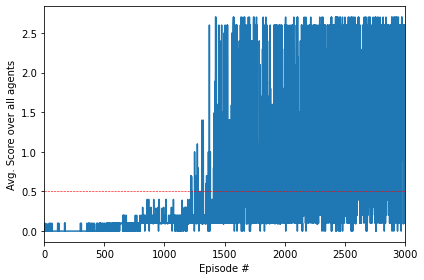

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
ax.plot([0,3000],[0.5,0.5], color='r', linestyle='--', linewidth=0.6)
ax.set_xlim(0, 3000)
plt.ylabel('Avg. Score over all agents')
plt.xlabel('Episode #')
# plt.show()
plt.tight_layout()
plt.savefig('figs/scores.eps')

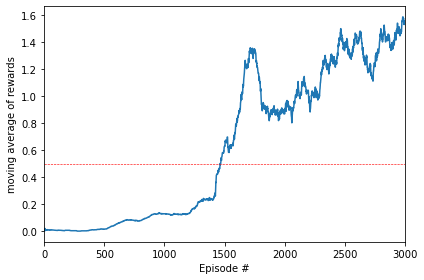

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(moving_averages)+1), moving_averages)
ax.plot([0,3000],[0.5,0.5], color='r', linestyle='--', linewidth=0.6)
ax.set_xlim(0, 3000)
plt.ylabel('moving average of rewards')
plt.xlabel('Episode #')
# plt.show()
plt.tight_layout()
plt.savefig('figs/moving_average.eps')

## watch agent play

In [13]:
for i, a in enumerate(agent.ddpg_agents):
    a.actor_local.load_state_dict(torch.load('actor_{}.pth'.format(i)))

In [12]:
def play(n_episodes=1):   
    for i_episode in range(1,n_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name]
        # get initial state
        states = env_info.vector_observations
        agent.reset()

        while True:
            # select actions for all agents
            actions = agent.act(states)
                       
            # send action to env
            env_info = env.step(actions)[brain_name]
            
            #observe new state, reward
            next_states = env_info.vector_observations
            rewards = env_info.rewards                         
            dones = env_info.local_done                      
            
            #update state
            states = next_states
            
            if any(dones):
                break

In [13]:
play()

In [14]:
env.close()